In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [3]:
def calculate_vwaps(data):
    b1 = data["bid_price_1"]
    b1v = data["bid_volume_1"]
    b2 = data["bid_price_2"]
    b2v = data["bid_volume_2"]
    b3 = data["bid_price_3"]
    b3v = data["bid_volume_3"]
    a1 = data["ask_price_1"]
    a1v = data["ask_volume_1"]
    a2 = data["ask_price_2"]
    a2v = data["ask_volume_2"]
    a3 = data["ask_price_3"]
    a3v = data["ask_volume_3"]

    bid_vwap = (b1 * b1v + b2 * b2v + b3 * b3v) / (b1v + b2v + b3v)
    ask_vwap = (a1 * a1v + a2 * a2v + a3 * a3v) / (a1v + a2v + a3v)
    vwap = (bid_vwap + ask_vwap) / 2
    return bid_vwap, ask_vwap, vwap

In [4]:
round = 2

DAY_2 = 2
DAY_1 = 1
DAY_0 = 0
days = [DAY_2, DAY_1, DAY_0]

products = ["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"]
day_data = {}

for day in days:
    activities, trades = from_csv(round, day, "../../data")
    product_data = {}
    for product in products:
        product_data[product] = activities[activities["product"] == product].reset_index()

        product_data[product]["spread"] = product_data[product]["ask_price_1"] - product_data[product]["bid_price_1"]
        bid_vwap, ask_vwap, vwap = calculate_vwaps(product_data[product])
        product_data[product]["bid_vwap"] = bid_vwap
        product_data[product]["ask_vwap"] = ask_vwap
        product_data[product]["vwap"] = vwap

    day_data[day] = product_data


for day in days:
    synthetic_pb1_mid = 6 * day_data[day]["CROISSANTS"]["mid_price"] + 3 * day_data[day]["JAMS"]["mid_price"] + day_data[day]["DJEMBES"]["mid_price"]
    synthetic_pb1_ask = 6 * day_data[day]["CROISSANTS"]["ask_price_1"] + 3 * day_data[day]["JAMS"]["ask_price_1"] + day_data[day]["DJEMBES"]["ask_price_1"]
    synthetic_pb1_bid = 6 * day_data[day]["CROISSANTS"]["bid_price_1"] + 3 * day_data[day]["JAMS"]["bid_price_1"] + day_data[day]["DJEMBES"]["bid_price_1"]
    synthetic_pb1_vask = 6 * day_data[day]["CROISSANTS"]["ask_vwap"] + 3 * day_data[day]["JAMS"]["ask_vwap"] + day_data[day]["DJEMBES"]["ask_vwap"]
    synthetic_pb1_vbid = 6 * day_data[day]["CROISSANTS"]["bid_vwap"] + 3 * day_data[day]["JAMS"]["bid_vwap"] + day_data[day]["DJEMBES"]["bid_vwap"]
    synthetic_pb1_vwap = 6 * day_data[day]["CROISSANTS"]["vwap"] + 3 * day_data[day]["JAMS"]["vwap"] + day_data[day]["DJEMBES"]["vwap"]
    synthetic_pb1 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb1_mid,
        "ask_price_1": synthetic_pb1_ask,
        "bid_price_1": synthetic_pb1_bid,
        "ask_vwap": synthetic_pb1_vask,
        "bid_vwap": synthetic_pb1_vbid,
        "vwap": synthetic_pb1_vwap
    })
    synthetic_pb2_mid = 4 * day_data[day]["CROISSANTS"]["mid_price"] + 2 * day_data[day]["JAMS"]["mid_price"]
    synthetic_pb2_ask = 4 * day_data[day]["CROISSANTS"]["ask_price_1"] + 2 * day_data[day]["JAMS"]["ask_price_1"]
    synthetic_pb2_bid = 4 * day_data[day]["CROISSANTS"]["bid_price_1"] + 2 * day_data[day]["JAMS"]["bid_price_1"]
    synthetic_pb2_vask = 4 * day_data[day]["CROISSANTS"]["ask_vwap"] + 2 * day_data[day]["JAMS"]["ask_vwap"]
    synthetic_pb2_vbid = 4 * day_data[day]["CROISSANTS"]["bid_vwap"] + 2 * day_data[day]["JAMS"]["bid_vwap"]
    synthetic_pb2_vwap = 4 * day_data[day]["CROISSANTS"]["vwap"] + 2 * day_data[day]["JAMS"]["vwap"]
    synthetic_pb2 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb2_mid,
        "ask_price_1": synthetic_pb2_ask,
        "bid_price_1": synthetic_pb2_bid,
        "ask_vwap": synthetic_pb2_vask,
        "bid_vwap": synthetic_pb2_vbid,
        "vwap": synthetic_pb2_vwap
    })

    day_data[day]["SYN_PICNIC_BASKET1"] = synthetic_pb1
    day_data[day]["SYN_PICNIC_BASKET2"] = synthetic_pb2

In [5]:
combined_data = {}
for day in days:
    for product in day_data[day].keys():
        product_data = day_data[day][product]
        if product not in combined_data.keys():
            combined_data[product] = [product_data]
        else:
            product_data["timestamp"] += combined_data[product][-1]["timestamp"].max() + 100
            combined_data[product].append(product_data)

for product in combined_data.keys():
    combined_data[product] = pd.concat(combined_data[product], ignore_index=True).reset_index()

In [6]:
# Analyze each day separately or combine them
data = day_data[DAY_1]
# data = combined_data
time = data["CROISSANTS"]["timestamp"]

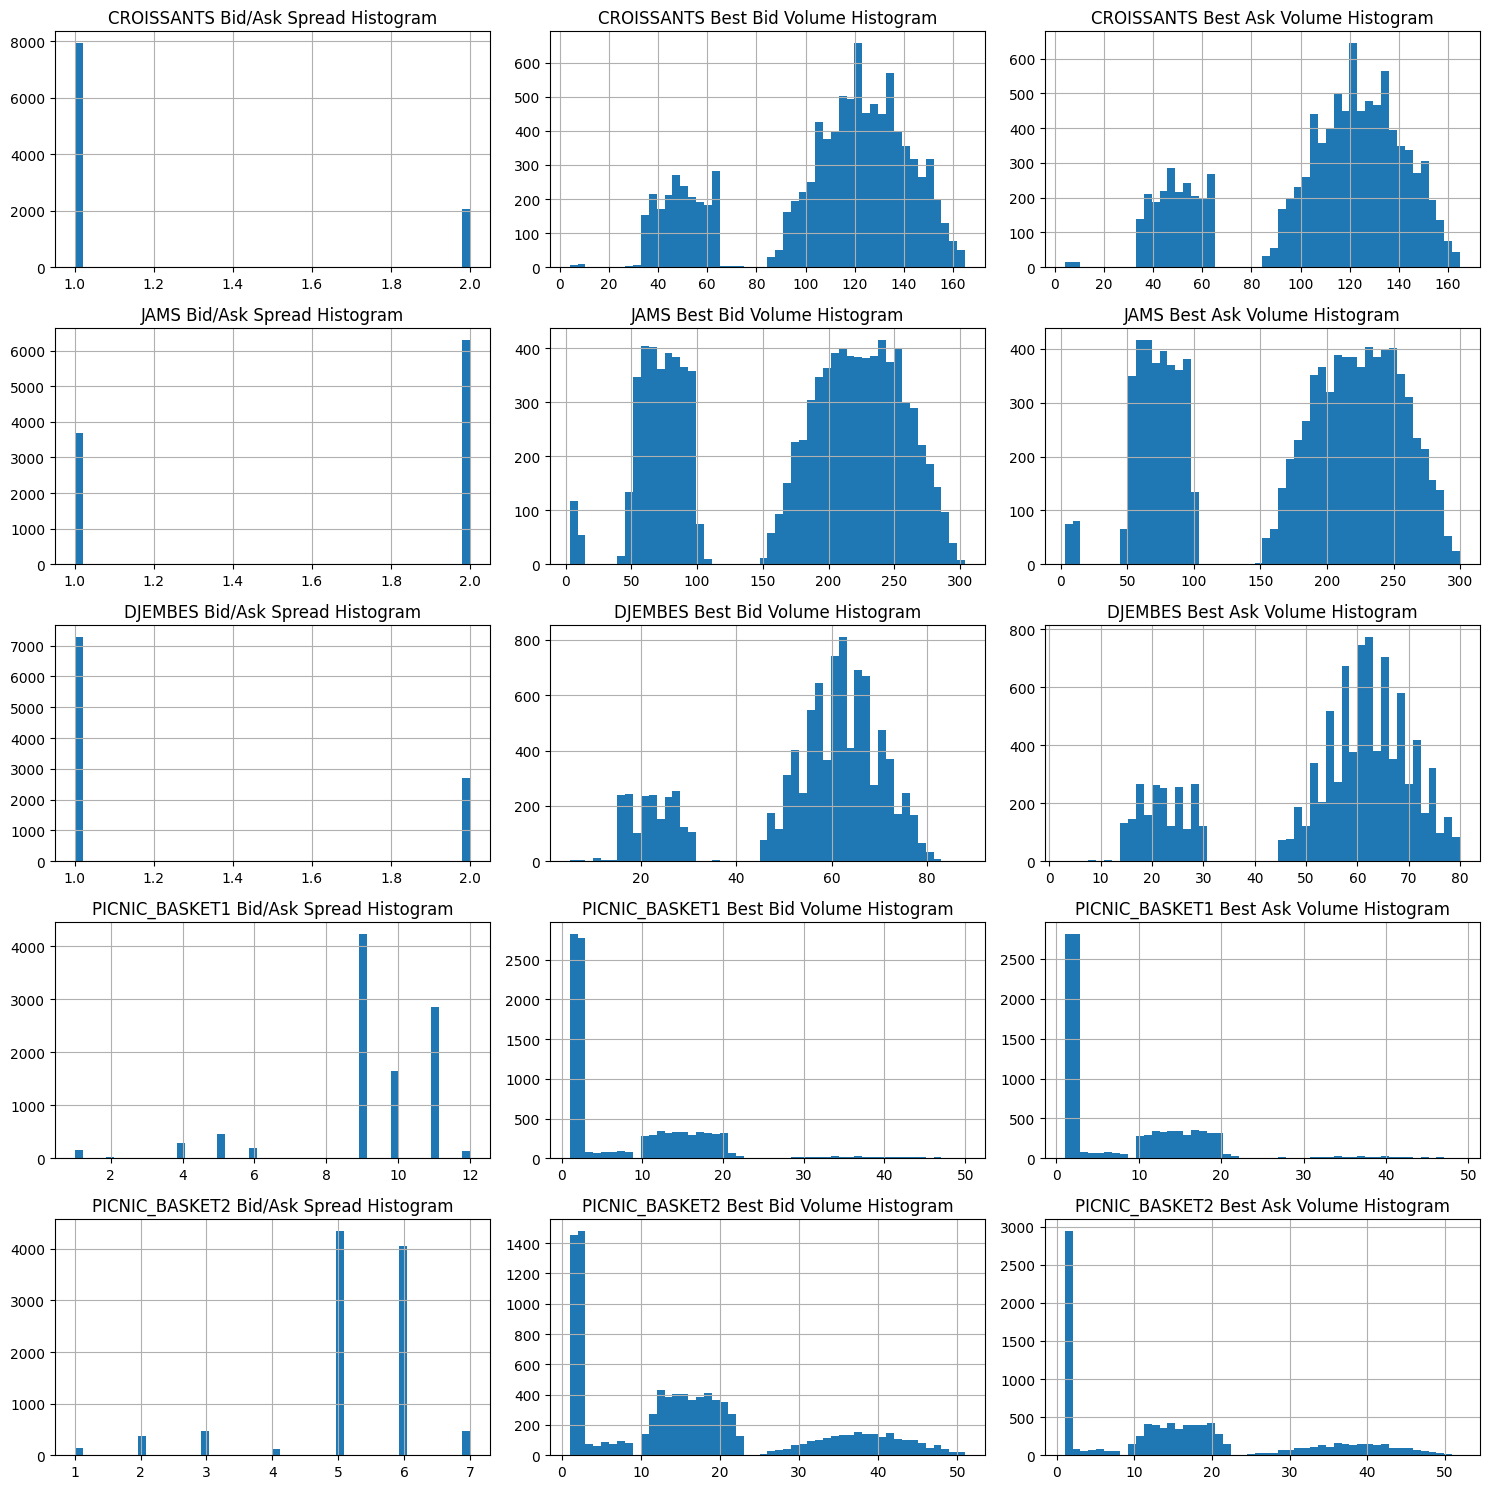

In [7]:
fig, axs = plt.subplots(len(products), 3, figsize=(15, 15))
for i, product in enumerate(products):
    for j in range(3):
        if j == 0:
            axs[i, j].hist(data[product]["spread"], bins=50)
            axs[i, j].set_title(f"{product} Bid/Ask Spread Histogram")
            axs[i, j].grid()
        elif j == 1:
            axs[i, j].hist(data[product]["bid_volume_1"], bins=50)
            axs[i, j].set_title(f"{product} Best Bid Volume Histogram")
            axs[i, j].grid()
        else:
            axs[i, j].hist(data[product]["ask_volume_1"], bins=50)
            axs[i, j].set_title(f"{product} Best Ask Volume Histogram")
            axs[i, j].grid()

plt.tight_layout()
# plt.savefig("figures/new_products_price_histograms.png")

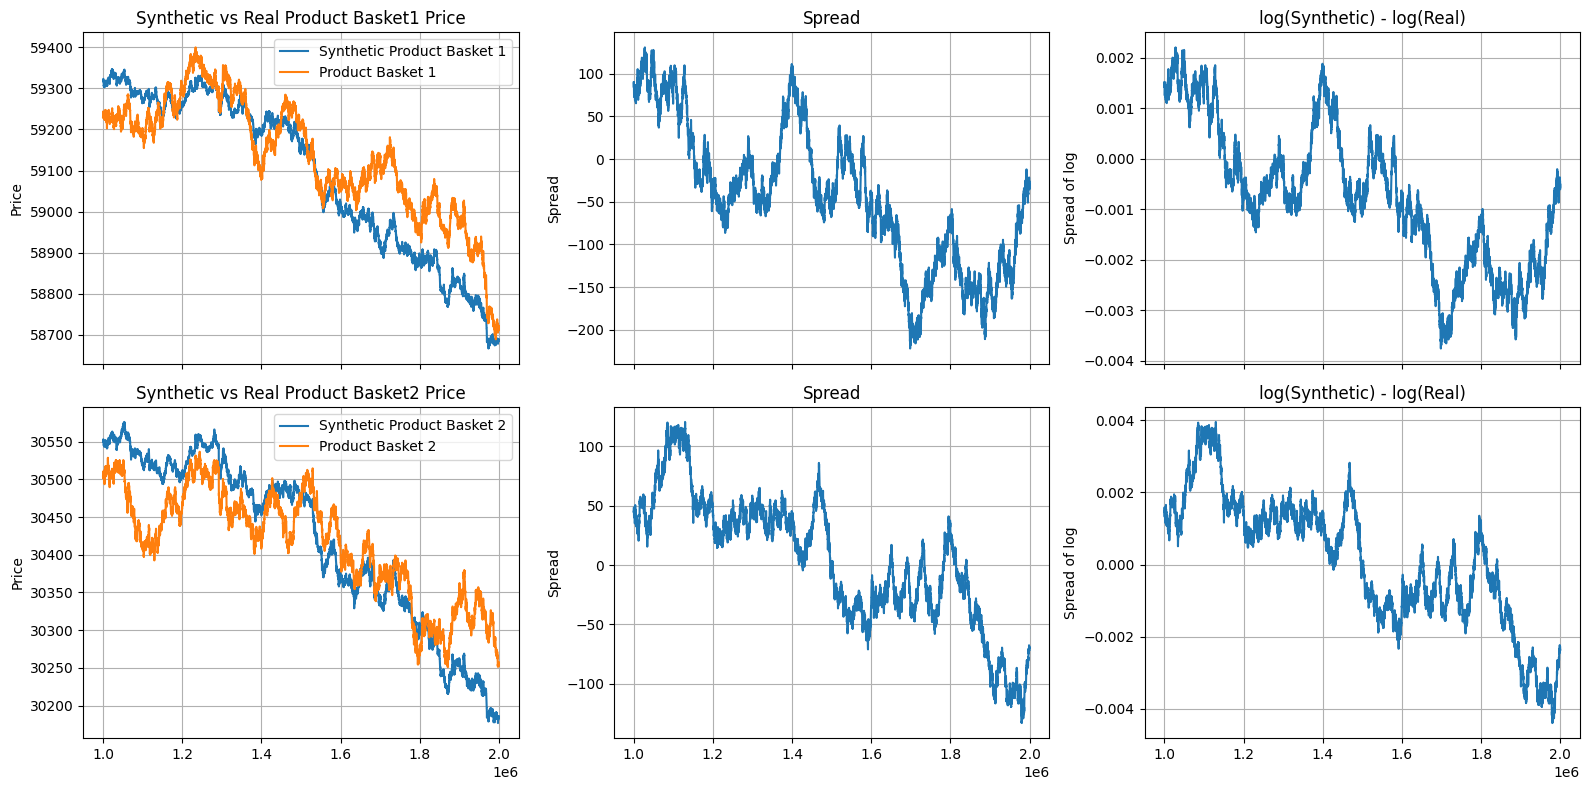

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8), sharex=True)

for i in range(2):
    axs[i, 0].plot(time, data[f"SYN_PICNIC_BASKET{i+1}"]["mid_price"], label=f"Synthetic Product Basket {i+1}")
    axs[i, 0].plot(time, data[f"PICNIC_BASKET{i+1}"]["mid_price"], label=f"Product Basket {i+1}")
    axs[i, 0].grid()
    axs[i, 0].legend()
    axs[i, 0].set_ylabel("Price")
    axs[i, 0].set_title(f"Synthetic vs Real Product Basket{i+1} Price")

    spread = data[f"SYN_PICNIC_BASKET{i+1}"]["mid_price"] - data[f"PICNIC_BASKET{i+1}"]["mid_price"]
    axs[i, 1].plot(time, spread, label="Spread")
    axs[i, 1].grid()
    axs[i, 1].set_ylabel("Spread")
    axs[i, 1].set_title("Spread")

    ratio = np.log(data[f"SYN_PICNIC_BASKET{i+1}"]["mid_price"]) - np.log(data[f"PICNIC_BASKET{i+1}"]["mid_price"])
    axs[i, 2].plot(time, ratio)
    axs[i, 2].grid()
    axs[i, 2].set_ylabel("Spread of log")
    axs[i, 2].set_title("log(Synthetic) - log(Real)")

plt.tight_layout()
# plt.savefig("figures/synthetic_vs_real.png")

In [13]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller

def interpret_adf(result):
    p_val = result[1]

    print(f"p-value: {p_val:.4f}")
    
    # Interpretation
    if p_val < 0.05:
        print("Result: Series is STATIONARY ")
       
    else:
        print("Result: Series is NON-STATIONARY")

print("Correlation between synthetic and real Product Basket 1")
corr, p_value = stats.pearsonr(data["SYN_PICNIC_BASKET1"]["mid_price"], data["PICNIC_BASKET1"]["mid_price"])
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")
print("Synthetic PB1 returns:")
syn_pb1_returns = np.diff(data["SYN_PICNIC_BASKET1"]["mid_price"]) / data["SYN_PICNIC_BASKET1"]["mid_price"][:-1]
interpret_adf(adfuller(syn_pb1_returns))
pb1_returns = np.diff(data["PICNIC_BASKET1"]["mid_price"]) / data["PICNIC_BASKET1"]["mid_price"][:-1]
print("PB1 returns:")
interpret_adf(adfuller(pb1_returns))

print()

print("Correlation between synthetic and real Product Basket 2")
corr, p_value = stats.pearsonr(data["SYN_PICNIC_BASKET2"]["mid_price"], data["PICNIC_BASKET2"]["mid_price"])
print(f"Pearson correlation coefficient: {corr}")
print(f"P-value: {p_value}")
print("Synthetic PB2 returns:")
syn_pb2_returns = np.diff(data["SYN_PICNIC_BASKET2"]["mid_price"]) / data["SYN_PICNIC_BASKET2"]["mid_price"][:-1]
interpret_adf(adfuller(syn_pb2_returns))
pb2_returns = np.diff(data["PICNIC_BASKET2"]["mid_price"]) / data["PICNIC_BASKET2"]["mid_price"][:-1]
print("PB2 returns:")
interpret_adf(adfuller(pb2_returns))

Correlation between synthetic and real Product Basket 1
Pearson correlation coefficient: 0.9258279455654015
P-value: 0.0
Synthetic PB1 returns:
p-value: 0.0000
Result: Series is STATIONARY 
PB1 returns:
p-value: 0.0000
Result: Series is STATIONARY 

Correlation between synthetic and real Product Basket 2
Pearson correlation coefficient: 0.9129238794871788
P-value: 0.0
Synthetic PB2 returns:
p-value: 0.0000
Result: Series is STATIONARY 
PB2 returns:
p-value: 0.0000
Result: Series is STATIONARY 


In [14]:
y1 = data["SYN_PICNIC_BASKET1"]["mid_price"]
y2 = data["PICNIC_BASKET1"]["mid_price"]
spread = y1 - y2
print("Spread between synthetic and real Product Basket 1")
interpret_adf(adfuller(spread))

print()
y1 = np.log(data["SYN_PICNIC_BASKET1"]["mid_price"])
y2 = np.log(data["PICNIC_BASKET1"]["mid_price"])
spread = y1 - y2
print("Ratio between synthetic and real Product Basket 1")
interpret_adf(adfuller(spread))

Spread between synthetic and real Product Basket 1
p-value: 0.1973
Result: Series is NON-STATIONARY

Ratio between synthetic and real Product Basket 1
p-value: 0.1985
Result: Series is NON-STATIONARY


In [15]:
pb1_bid = data["PICNIC_BASKET1"]["bid_price_1"]
pb1_ask = data["PICNIC_BASKET1"]["ask_price_1"]

cro_bid = data["CROISSANTS"]["bid_price_1"]
cro_ask = data["CROISSANTS"]["ask_price_1"]

jams_bid = data["JAMS"]["bid_price_1"]
jams_ask = data["JAMS"]["ask_price_1"]

dje_bid = data["DJEMBES"]["bid_price_1"]
dje_ask = data["DJEMBES"]["ask_price_1"]

spread_buy = pb1_bid - (6 * cro_ask + 3 * jams_ask + dje_ask)
spread_sell = pb1_ask - (6 * cro_bid + 3 * jams_bid + dje_bid)

z_score_buy = (spread_buy - np.mean(spread_buy)) / np.std(spread_buy)
z_score_sell = (spread_sell - np.mean(spread_sell)) / np.std(spread_sell)

open_buy_threshold = -1.5
close_buy_threshold = -0.5
open_sell_threshold = 1.5
close_sell_threshold = 0.5

In [18]:
spread_buy[:50]

0    -102
1     -99
2     -93
3    -101
4     -99
5     -96
6     -97
7     -84
8     -95
9     -87
10    -88
11    -89
12    -90
13    -95
14    -92
15    -94
16    -95
17    -94
18    -84
19    -82
20    -85
21    -88
22    -86
23    -89
24    -85
25    -84
26    -87
27    -88
28    -83
29    -84
30    -79
31    -79
32    -82
33    -87
34    -90
35    -87
36    -84
37    -90
38    -79
39    -80
40    -85
41    -88
42    -92
43    -96
44    -94
45    -94
46    -94
47    -94
48    -93
49    -89
dtype: int64

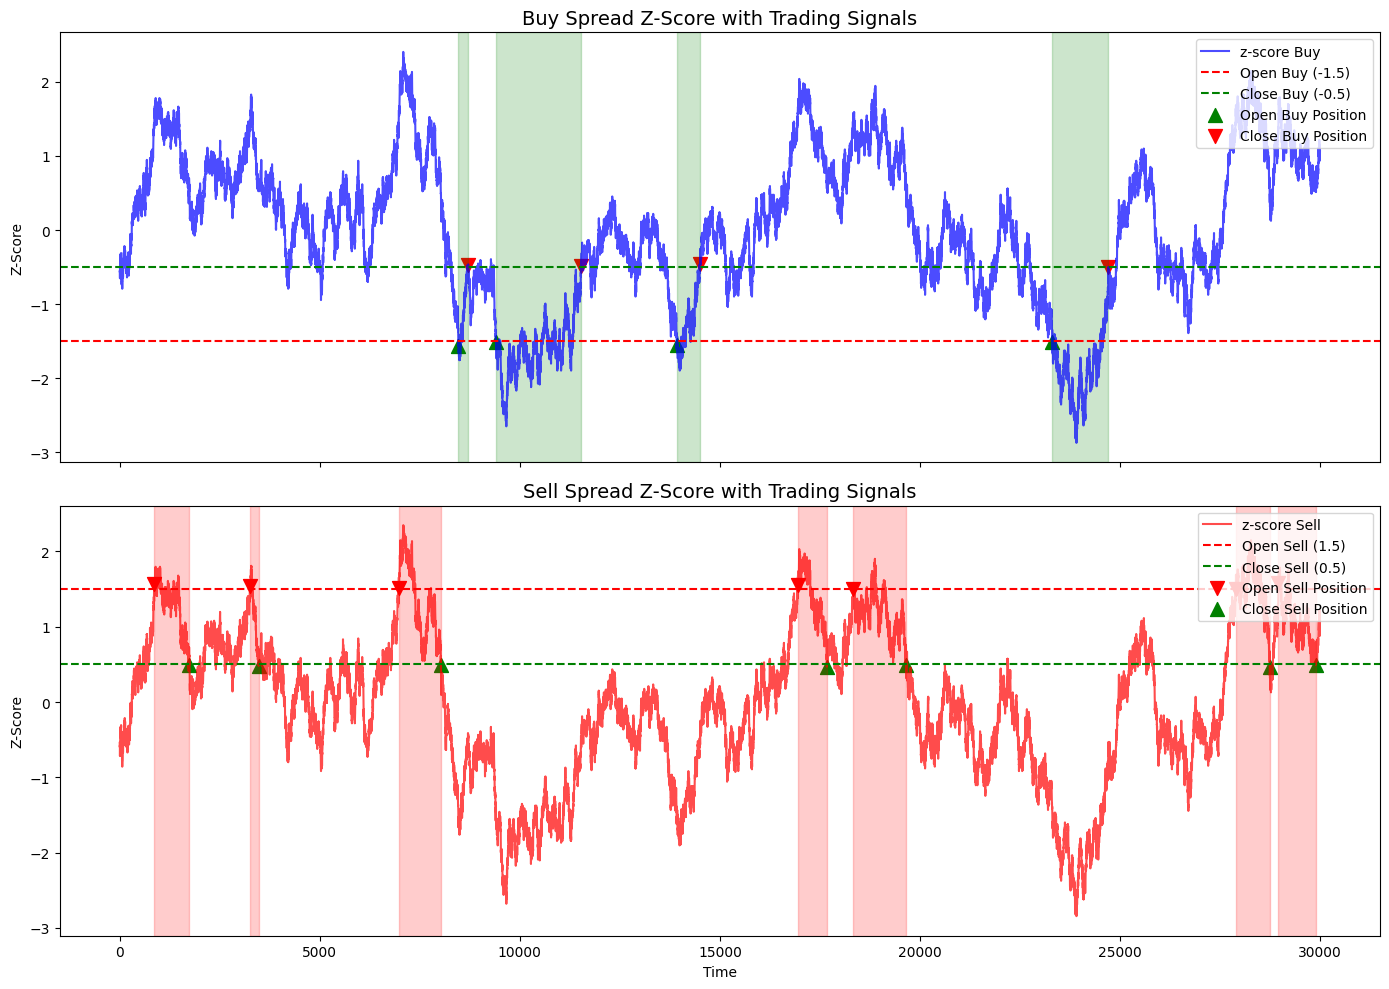

Number of buy positions: 4
Number of sell positions: 7


In [28]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot z-scores
ax1.plot(z_score_buy, color='blue', alpha=0.7, label='z-score Buy')
ax2.plot(z_score_sell, color='red', alpha=0.7, label='z-score Sell')

# Add threshold lines
ax1.axhline(y=open_buy_threshold, color='r', linestyle='--', label=f'Open Buy ({open_buy_threshold})')
ax1.axhline(y=close_buy_threshold, color='g', linestyle='--', label=f'Close Buy ({close_buy_threshold})')
ax2.axhline(y=open_sell_threshold, color='r', linestyle='--', label=f'Open Sell ({open_sell_threshold})')
ax2.axhline(y=close_sell_threshold, color='g', linestyle='--', label=f'Close Sell ({close_sell_threshold})')

# Find crossing points for buy signals
buy_position_open = []
buy_position_close = []
in_buy_position = False

for i in range(1, len(z_score_buy)):
    # Check for buy position open signal
    if not in_buy_position and z_score_buy[i-1] > open_buy_threshold and z_score_buy[i] <= open_buy_threshold:
        buy_position_open.append(i)
        in_buy_position = True
    # Check for buy position close signal
    elif in_buy_position and z_score_buy[i-1] < close_buy_threshold and z_score_buy[i] >= close_buy_threshold:
        buy_position_close.append(i)
        in_buy_position = False

# Find crossing points for sell signals
sell_position_open = []
sell_position_close = []
in_sell_position = False

for i in range(1, len(z_score_sell)):
    # Check for sell position open signal
    if not in_sell_position and z_score_sell[i-1] < open_sell_threshold and z_score_sell[i] >= open_sell_threshold:
        sell_position_open.append(i)
        in_sell_position = True
    # Check for sell position close signal
    elif in_sell_position and z_score_sell[i-1] > close_sell_threshold and z_score_sell[i] <= close_sell_threshold:
        sell_position_close.append(i)
        in_sell_position = False

# Plot the signals on the respective plots
for idx in buy_position_open:
    ax1.scatter(idx, z_score_buy[idx], color='green', s=100, marker='^', label='Open Buy Position' if idx == buy_position_open[0] else "")

for idx in buy_position_close:
    ax1.scatter(idx, z_score_buy[idx], color='red', s=100, marker='v', label='Close Buy Position' if idx == buy_position_close[0] else "")

for idx in sell_position_open:
    ax2.scatter(idx, z_score_sell[idx], color='red', s=100, marker='v', label='Open Sell Position' if idx == sell_position_open[0] else "")

for idx in sell_position_close:
    ax2.scatter(idx, z_score_sell[idx], color='green', s=100, marker='^', label='Close Sell Position' if idx == sell_position_close[0] else "")

# Add shading for active positions
for i in range(min(len(buy_position_open), len(buy_position_close))):
    ax1.axvspan(buy_position_open[i], buy_position_close[i], alpha=0.2, color='green')

for i in range(min(len(sell_position_open), len(sell_position_close))):
    ax2.axvspan(sell_position_open[i], sell_position_close[i], alpha=0.2, color='red')

# Add titles and legends
ax1.set_title('Buy Spread Z-Score with Trading Signals', fontsize=14)
ax2.set_title('Sell Spread Z-Score with Trading Signals', fontsize=14)
ax1.set_ylabel('Z-Score')
ax2.set_ylabel('Z-Score')
ax2.set_xlabel('Time')

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Number of buy positions: {len(buy_position_open)}")
print(f"Number of sell positions: {len(sell_position_open)}")

/Users/ashokolarov/opt/miniconda3/envs/quant/lib/python3.13/site-packages/numpy/_core/numeric.py:457: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


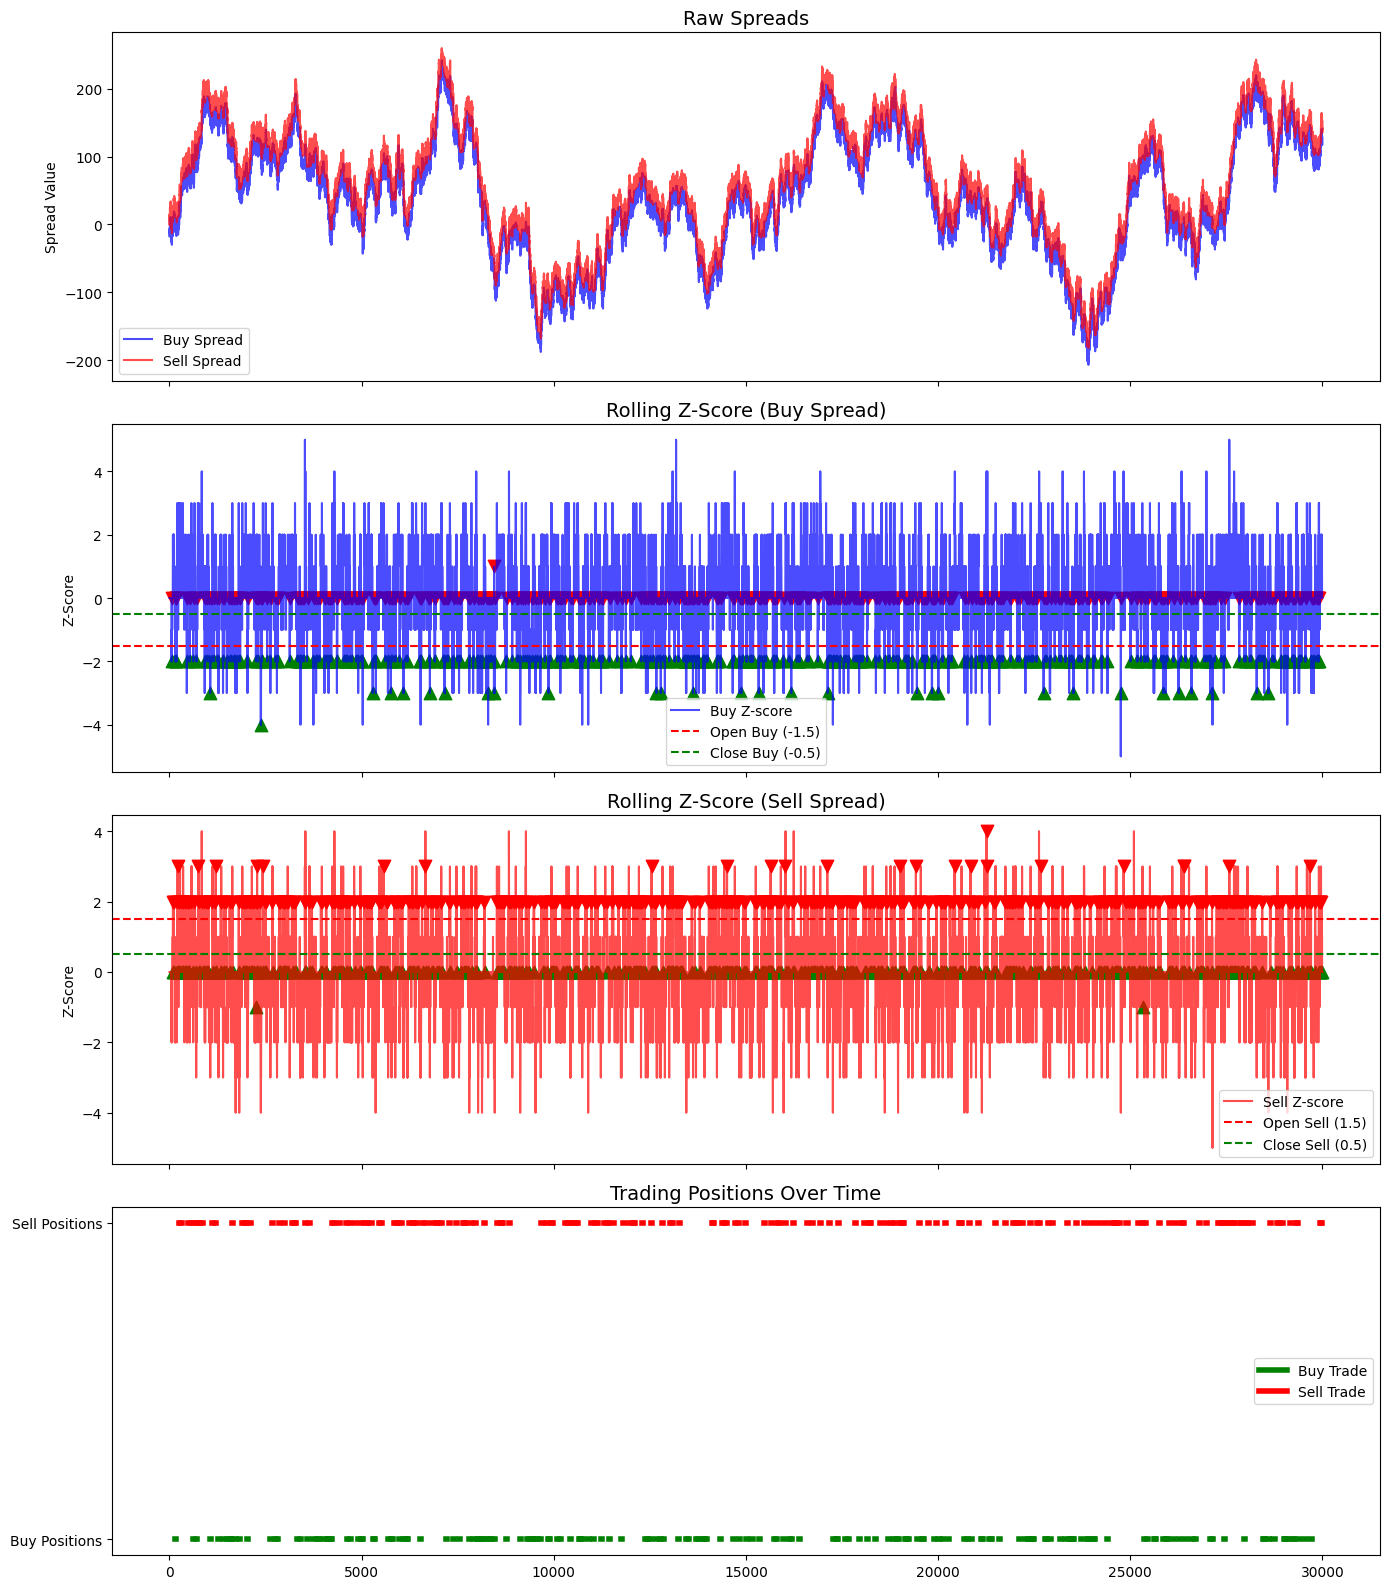

Using a 50-period rolling window for calculating z-scores

Buy Trading Statistics:
Number of trades: 437
Average return per trade: 3.7025
Win rate: 77.12%

Sell Trading Statistics:
Number of trades: {len(sell_exits)}
Average return per trade: 4.1629
Win rate: 78.00%


In [30]:
# Define parameters
window_size = 50  # Number of periods to use for rolling statistics

# Extract the price data
pb1_bid = data["PICNIC_BASKET1"]["bid_price_1"]
pb1_ask = data["PICNIC_BASKET1"]["ask_price_1"]
cro_bid = data["CROISSANTS"]["bid_price_1"]
cro_ask = data["CROISSANTS"]["ask_price_1"]
jams_bid = data["JAMS"]["bid_price_1"]
jams_ask = data["JAMS"]["ask_price_1"]
dje_bid = data["DJEMBES"]["bid_price_1"]
dje_ask = data["DJEMBES"]["ask_price_1"]

# Calculate raw spreads
spread_buy = pb1_bid - (6 * cro_ask + 3 * jams_ask + dje_ask)
spread_sell = pb1_ask - (6 * cro_bid + 3 * jams_bid + dje_bid)

# Initialize arrays for the rolling z-scores
z_score_buy_rolling = np.full_like(spread_buy, np.nan)
z_score_sell_rolling = np.full_like(spread_sell, np.nan)

# Position tracking
in_buy_position = False
in_sell_position = False
buy_entries = []
buy_exits = []
sell_entries = []
sell_exits = []
buy_entry_prices = []
buy_exit_prices = []
sell_entry_prices = []
sell_exit_prices = []

# Simulate real-time trading
for i in range(window_size, len(spread_buy)):
    # Get the window of data up to current point
    window_buy = spread_buy[i-window_size:i]
    window_sell = spread_sell[i-window_size:i]
    
    # Calculate rolling stats
    mean_buy = np.mean(window_buy)
    std_buy = np.std(window_buy)
    mean_sell = np.mean(window_sell)
    std_sell = np.std(window_sell)
    
    # Calculate z-scores based on rolling stats
    z_score_buy_rolling[i] = (spread_buy[i] - mean_buy) / std_buy
    z_score_sell_rolling[i] = (spread_sell[i] - mean_sell) / std_sell
    
    # Trading logic for buy spread
    if not in_buy_position and z_score_buy_rolling[i] <= open_buy_threshold:
        buy_entries.append(i)
        buy_entry_prices.append(spread_buy[i])
        in_buy_position = True
    elif in_buy_position and z_score_buy_rolling[i] >= close_buy_threshold:
        buy_exits.append(i)
        buy_exit_prices.append(spread_buy[i])
        in_buy_position = False
    
    # Trading logic for sell spread
    if not in_sell_position and z_score_sell_rolling[i] >= open_sell_threshold:
        sell_entries.append(i)
        sell_entry_prices.append(spread_sell[i])
        in_sell_position = True
    elif in_sell_position and z_score_sell_rolling[i] <= close_sell_threshold:
        sell_exits.append(i)
        sell_exit_prices.append(spread_sell[i])
        in_sell_position = False

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 16), sharex=True)

# Plot raw spreads
ax1.plot(spread_buy, label='Buy Spread', color='blue', alpha=0.7)
ax1.plot(spread_sell, label='Sell Spread', color='red', alpha=0.7)
ax1.set_title('Raw Spreads', fontsize=14)
ax1.set_ylabel('Spread Value')
ax1.legend()

# Plot rolling z-scores with thresholds
ax2.plot(z_score_buy_rolling, label='Buy Z-score', color='blue', alpha=0.7)
ax2.axhline(y=open_buy_threshold, color='red', linestyle='--', label=f'Open Buy ({open_buy_threshold})')
ax2.axhline(y=close_buy_threshold, color='green', linestyle='--', label=f'Close Buy ({close_buy_threshold})')
ax2.set_title('Rolling Z-Score (Buy Spread)', fontsize=14)
ax2.set_ylabel('Z-Score')
ax2.legend()

ax3.plot(z_score_sell_rolling, label='Sell Z-score', color='red', alpha=0.7)
ax3.axhline(y=open_sell_threshold, color='red', linestyle='--', label=f'Open Sell ({open_sell_threshold})')
ax3.axhline(y=close_sell_threshold, color='green', linestyle='--', label=f'Close Sell ({close_sell_threshold})')
ax3.set_title('Rolling Z-Score (Sell Spread)', fontsize=14)
ax3.set_ylabel('Z-Score')
ax3.legend()

# Plot trades
for i, (entry, exit) in enumerate(zip(buy_entries, buy_exits)):
    ax4.plot([entry, exit], [0, 0], 'g-', linewidth=4, label='Buy Trade' if i == 0 else "")
    
for i, (entry, exit) in enumerate(zip(sell_entries, sell_exits)):
    ax4.plot([entry, exit], [1, 1], 'r-', linewidth=4, label='Sell Trade' if i == 0 else "")

ax4.set_yticks([0, 1])
ax4.set_yticklabels(['Buy Positions', 'Sell Positions'])
ax4.set_title('Trading Positions Over Time', fontsize=14)
ax4.legend()

# Add trade markers to z-score plots
for idx in buy_entries:
    ax2.scatter(idx, z_score_buy_rolling[idx], color='green', s=80, marker='^')
for idx in buy_exits:
    ax2.scatter(idx, z_score_buy_rolling[idx], color='red', s=80, marker='v')
    
for idx in sell_entries:
    ax3.scatter(idx, z_score_sell_rolling[idx], color='red', s=80, marker='v')
for idx in sell_exits:
    ax3.scatter(idx, z_score_sell_rolling[idx], color='green', s=80, marker='^')

# Calculate and display performance metrics
if buy_entries and buy_exits:
    if len(buy_entries) > len(buy_exits):
        buy_entries = buy_entries[:len(buy_exits)]  # Trim if position still open at end
    buy_returns = [(exit_price - entry_price) for entry_price, exit_price in zip(buy_entry_prices, buy_exit_prices)]
    avg_buy_return = np.mean(buy_returns) if buy_returns else 0
    win_rate_buy = np.sum(np.array(buy_returns) > 0) / len(buy_returns) if buy_returns else 0
    
if sell_entries and sell_exits:
    if len(sell_entries) > len(sell_exits):
        sell_entries = sell_entries[:len(sell_exits)]  # Trim if position still open at end
    sell_returns = [(entry_price - exit_price) for entry_price, exit_price in zip(sell_entry_prices, sell_exit_prices)]
    avg_sell_return = np.mean(sell_returns) if sell_returns else 0
    win_rate_sell = np.sum(np.array(sell_returns) > 0) / len(sell_returns) if sell_returns else 0

plt.tight_layout()
plt.show()

# Print statistics
print(f"Using a {window_size}-period rolling window for calculating z-scores")
print("\nBuy Trading Statistics:")
print(f"Number of trades: {len(buy_exits)}")
if buy_entries and buy_exits:
    print(f"Average return per trade: {avg_buy_return:.4f}")
    print(f"Win rate: {win_rate_buy:.2%}")

print("\nSell Trading Statistics:")
print("Number of trades: {len(sell_exits)}")
if sell_entries and sell_exits:
    print(f"Average return per trade: {avg_sell_return:.4f}")
    print(f"Win rate: {win_rate_sell:.2%}")